In [8]:
# ! wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1z7rXRIFtRBFZHt-Mmti4HxrxHqUfG3Y8' -O /content/drive/MyDrive/Dataset/Tensorflow_GAN_Color_Image_Generation/tf-book.zip

In [9]:
# !unzip /content/drive/MyDrive/Dataset/Tensorflow_GAN_Color_Image_Generation/tf-book.zip

In [10]:
import os
import sys
import time
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import UpSampling2D, Conv2D

**Creating Dataset**

In [11]:
def load_dataset(batch_size, img_shape, data_dir = None):
  # Create a tuple of size(30000,64,64,3)
  sample_dim = (batch_size,) + img_shape

  # Create an uninitialized array of shape (30000,64,64,3)
  sample = np.empty(sample_dim, dtype=np.float32)

  # Extract all images from our file
  all_data_dirlist = list(glob.glob(data_dir))

  # Randomly select an image file from our data list
  sample_imgs_paths = np.random.choice(all_data_dirlist, batch_size)

  for index,img_filename in enumerate(sample_imgs_paths):
    # Open the image
    image = Image.open(img_filename)

    # Resize the image
    image = image.resize(img_shape[:-1])

    # Convert the input into an array
    image = np.asarray(image)

    # Normalize data
    image = (image/127.5) -1

    # Assign the preprocessed image to our sample
    sample[index,...] = image
    
  print("Data loaded")
  return sample

In [12]:
x_train=load_dataset(30000,(64,64,3),"/content/tf-book/chapter13/anime/data/*.png")
BUFFER_SIZE = 30000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Data loaded


**Displaying Images**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wi

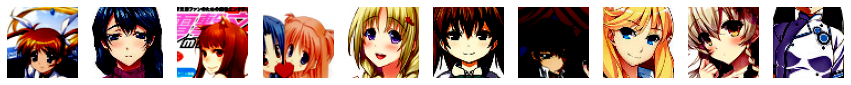

In [13]:
n = 10
f = plt.figure(figsize=(15,15))
for i in range(n):
  f.add_subplot(1, n, i + 1)
  plt.subplot(1, n, i+1 ).axis("off")
  plt.imshow(x_train[i])
plt.show()

In [14]:
x_train.shape

(30000, 64, 64, 3)

**Defining generator model:**


In [15]:
gen_model = tf.keras.Sequential()

# seed image of size 4x4
gen_model.add(tf.keras.layers.Dense(64*4*4, use_bias=False, input_shape=(100,)))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())
gen_model.add(tf.keras.layers.Reshape((4,4,64)))

# size of output image is still 4x4
gen_model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# size of output image is 8x8
gen_model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# size of output image is 16x16
gen_model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# size of output image is 32x32
gen_model.add(tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# size of output image is 64x64
gen_model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

In [16]:
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              102400    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0

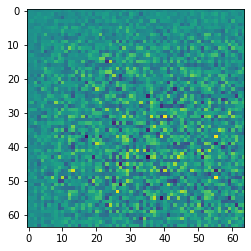

In [17]:
noise = tf.random.normal([1, 100])
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0] )

**Defining Discriminator model:**

In [18]:
discri_model = tf.keras.Sequential()
discri_model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[64,64,3]))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
discri_model.add(tf.keras.layers.Flatten())
discri_model.add(tf.keras.layers.Dense(1))

In [19]:
discri_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)            

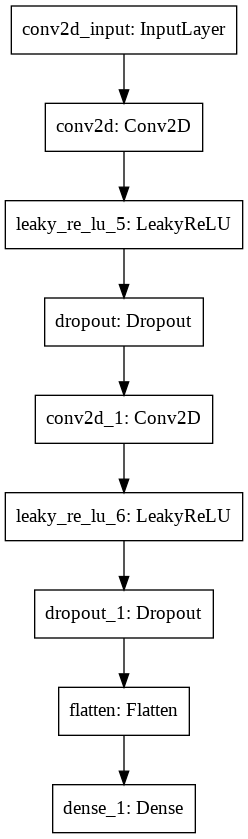

In [20]:
tf.keras.utils.plot_model(discri_model)

In [21]:
decision = discri_model(generated_image)
#giving the generated image to discriminator,the discriminator will give negative value if it is fake,while if it is real then it will give positive value.
print (decision)

tf.Tensor([[3.8967293e-05]], shape=(1, 1), dtype=float32)


**Defining Loss Functions**

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(generated_output):
  return cross_entropy(tf.ones_like(generated_output), generated_output)

In [24]:
def discriminator_loss(real_output, generated_output):
  # compute loss considering the image is real [1,1,...,1]
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)

  # compute loss considering the image is fake[0,0,...,0]
  generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)

  # compute total loss
  total_loss = real_loss + generated_loss
  
  return total_loss

**Optimisers**

In [25]:
gen_optimizer = tf.optimizers.Adam(1e-4)
discri_optimizer = tf.optimizers.Adam(1e-4)

**Defining Few Functions for Training**

In [26]:
epoch_number = 0
EPOCHS = 10000
noise_dim = 100
seed = tf.random.normal([1, noise_dim])

**Checkpoint Setup**

In [27]:
checkpoint_dir = '/content/drive/MyDrive/Dataset/TensorFlow_GAN_CheckPoint_Output'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [28]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer = gen_optimizer,
    discriminator_optimizer = discri_optimizer,
    generator = gen_model,
    discriminator = discri_model
)

**Model Training Step**

In [29]:
def gradient_tuning(images):
  # create a noise vector.
  noise = tf.random.normal([16, noise_dim])

  # Use gradient tapes for automatic
  # differentiation
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
    # ask genertor to generate random images
    generated_images = gen_model(noise, training=True)

    # ask discriminator to evalute the real images and generate its output
    real_output = discri_model(images, training = True)
    # ask discriminator to do the evlaution on generated(fake) images
    fake_output = discri_model(generated_images, training = True)

    # calculate generator loss on fake data
    gen_loss = generator_loss(fake_output)

    # calculate discriminator loss as defined earlier
    disc_loss = discriminator_loss(real_output, fake_output)
  
    # calculate gradients for generator
    gen_gradients = generator_tape.gradient(gen_loss, gen_model.trainable_variables)

    # calculate gradients for discriminator
    discri_gradients = discriminator_tape.gradient(disc_loss, discri_model.trainable_variables)

    # use optimizer to process and apply gradients to variables
    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    
    # same as above to discriminator
    discri_optimizer.apply_gradients(zip(discri_gradients, discri_model.trainable_variables))

In [30]:
def generate_and_save_images(model, epoch, test_input):
  global epoch_number
  epoch_number = epoch_number + 1

  # set training to false to ensure inference mode
  predictions = model(test_input, training = False)

  # display and save image
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:01d}.png'.format(epoch_number))
  plt.show()

**Model Training**

In [31]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      gradient_tuning(image_batch)

    # Produce images as we go
    generate_and_save_images(gen_model, epoch + 1, seed)

    # save checkpoint data
    checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format (epoch + 1, time.time()-start))

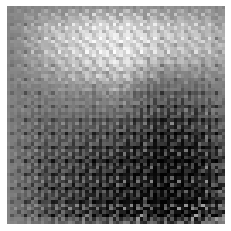

Time for epoch 1 is 21.3808376789093 sec


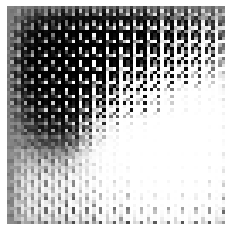

Time for epoch 2 is 17.727653980255127 sec


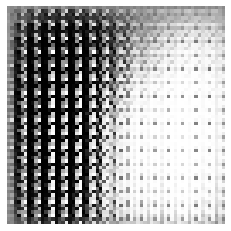

Time for epoch 3 is 16.906739473342896 sec


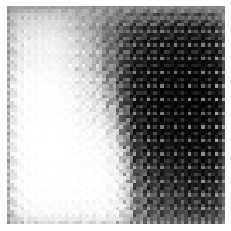

Time for epoch 4 is 17.074960947036743 sec


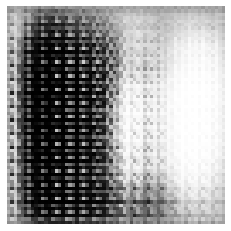

Time for epoch 5 is 17.16100025177002 sec


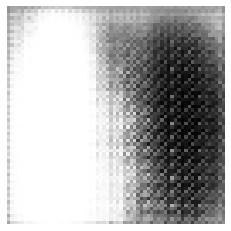

Time for epoch 6 is 17.346805810928345 sec


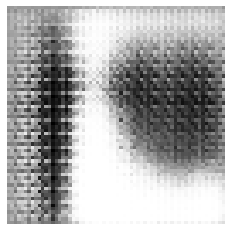

Time for epoch 7 is 17.4347722530365 sec


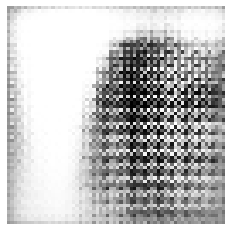

Time for epoch 8 is 17.06316304206848 sec


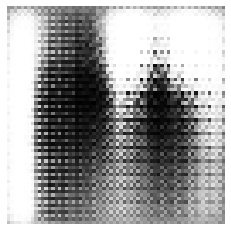

Time for epoch 9 is 16.9427707195282 sec


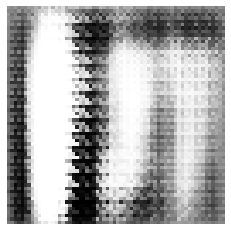

Time for epoch 10 is 16.815891981124878 sec


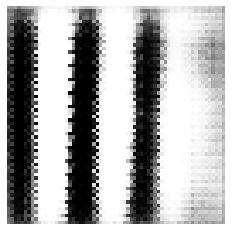

Time for epoch 11 is 16.870495796203613 sec


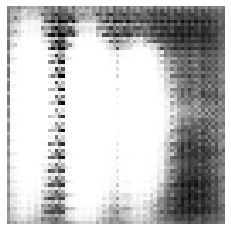

Time for epoch 12 is 16.743147373199463 sec


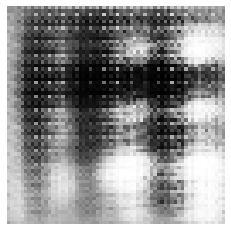

Time for epoch 13 is 16.737550973892212 sec


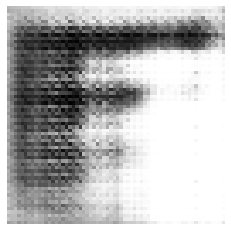

Time for epoch 14 is 16.79107975959778 sec


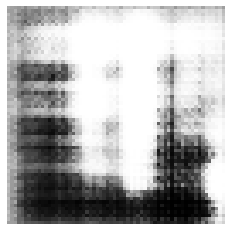

Time for epoch 15 is 16.810323238372803 sec


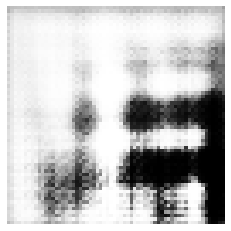

Time for epoch 16 is 17.04640030860901 sec


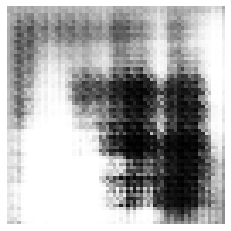

Time for epoch 17 is 17.094766855239868 sec


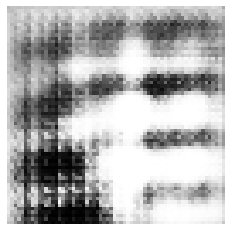

Time for epoch 18 is 16.769381523132324 sec


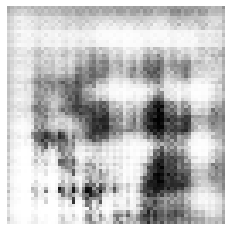

Time for epoch 19 is 16.75524663925171 sec


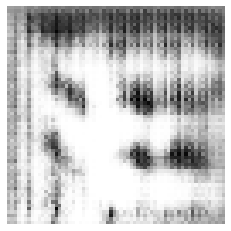

Time for epoch 20 is 16.80287003517151 sec


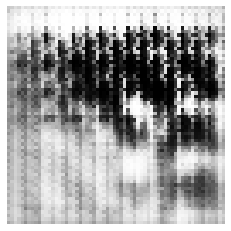

Time for epoch 21 is 16.793335676193237 sec


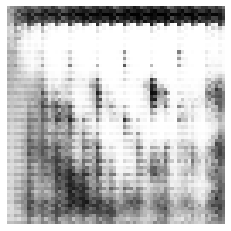

Time for epoch 22 is 16.758474826812744 sec


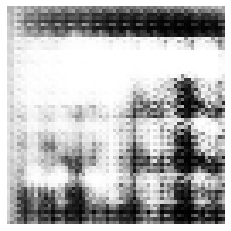

Time for epoch 23 is 16.877699375152588 sec


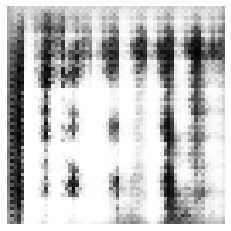

Time for epoch 24 is 16.748170375823975 sec


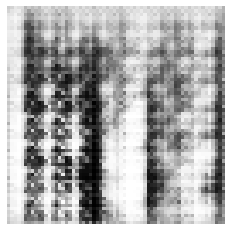

Time for epoch 25 is 16.739436864852905 sec


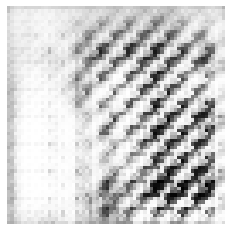

Time for epoch 26 is 16.794919967651367 sec


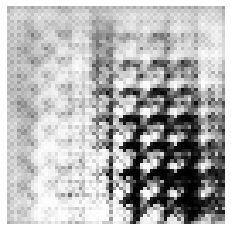

Time for epoch 27 is 16.84325337409973 sec


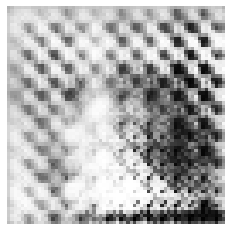

Time for epoch 28 is 16.75585961341858 sec


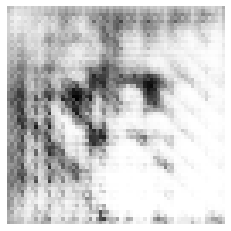

Time for epoch 29 is 16.818147659301758 sec


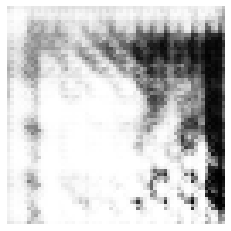

Time for epoch 30 is 17.076784133911133 sec


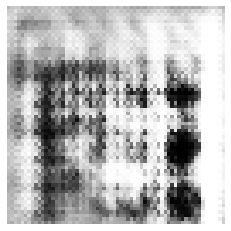

Time for epoch 31 is 17.208691358566284 sec


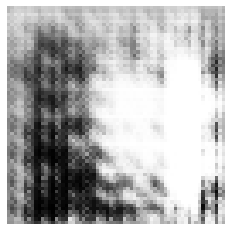

Time for epoch 32 is 16.778204441070557 sec


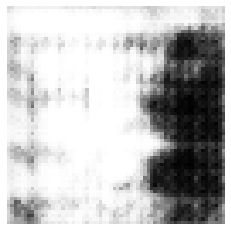

Time for epoch 33 is 16.858547925949097 sec


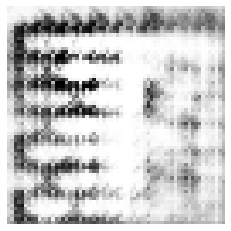

Time for epoch 34 is 17.000258922576904 sec


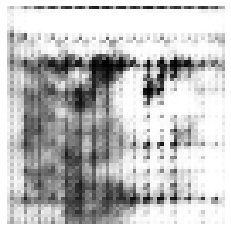

Time for epoch 35 is 16.728424549102783 sec


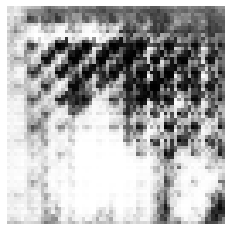

Time for epoch 36 is 16.732643842697144 sec


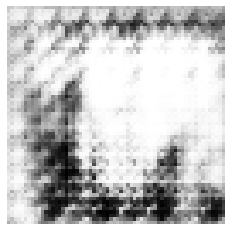

Time for epoch 37 is 16.828298807144165 sec


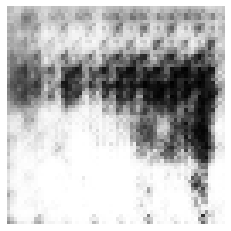

Time for epoch 38 is 16.88372039794922 sec


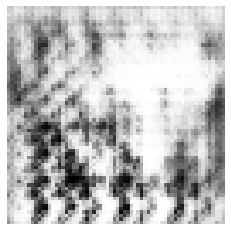

Time for epoch 39 is 16.760132551193237 sec


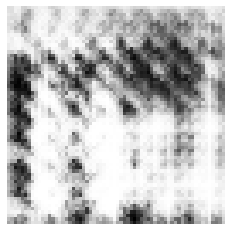

Time for epoch 40 is 16.735873699188232 sec


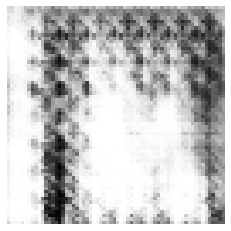

Time for epoch 41 is 16.801413774490356 sec


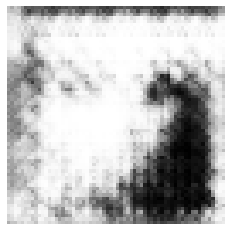

Time for epoch 42 is 16.760934829711914 sec


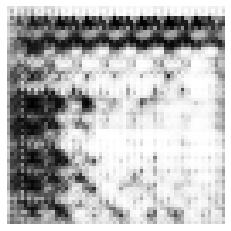

Time for epoch 43 is 16.733474731445312 sec


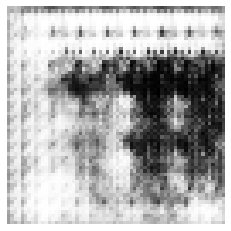

Time for epoch 44 is 16.74337363243103 sec


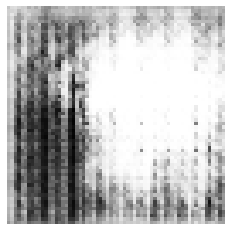

Time for epoch 45 is 16.727585554122925 sec


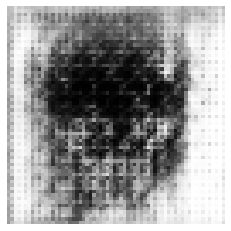

Time for epoch 46 is 16.756402015686035 sec


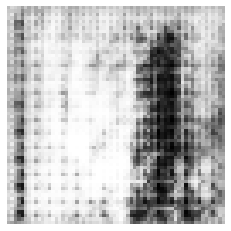

Time for epoch 47 is 16.761729955673218 sec


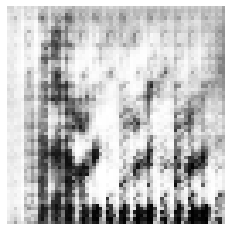

Time for epoch 48 is 16.84568190574646 sec


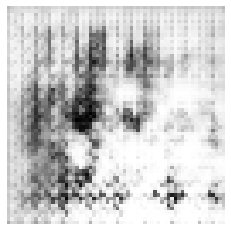

Time for epoch 49 is 16.766485929489136 sec


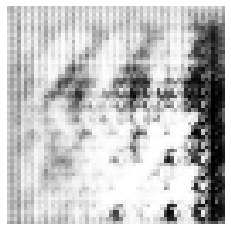

Time for epoch 50 is 16.87418508529663 sec


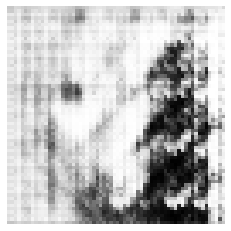

Time for epoch 51 is 16.806290864944458 sec


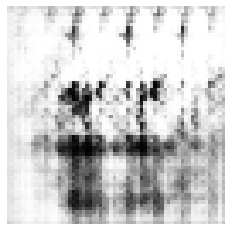

Time for epoch 52 is 16.948615789413452 sec


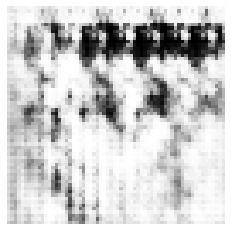

Time for epoch 53 is 17.069071054458618 sec


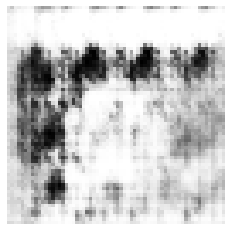

Time for epoch 54 is 16.8447687625885 sec


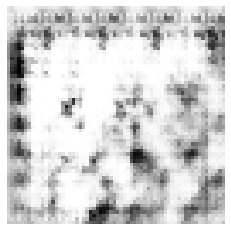

Time for epoch 55 is 17.072896003723145 sec


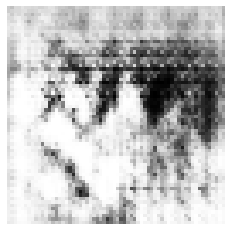

Time for epoch 56 is 16.888142108917236 sec


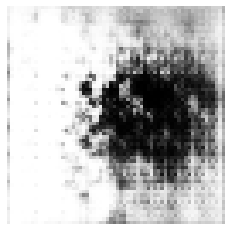

Time for epoch 57 is 16.847412109375 sec


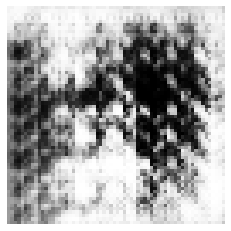

Time for epoch 58 is 16.911731004714966 sec


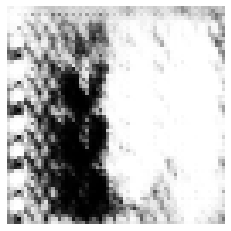

Time for epoch 59 is 16.855777263641357 sec


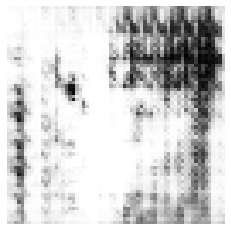

Time for epoch 60 is 16.869624614715576 sec


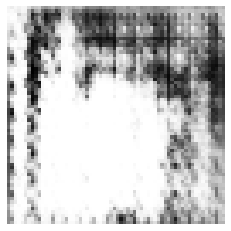

Time for epoch 61 is 16.794832229614258 sec


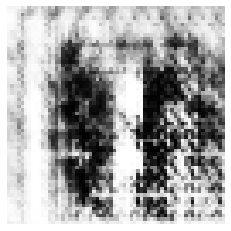

Time for epoch 62 is 16.810080766677856 sec


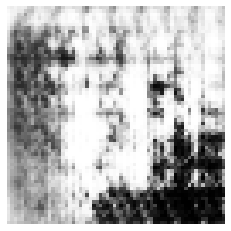

Time for epoch 63 is 16.735586643218994 sec


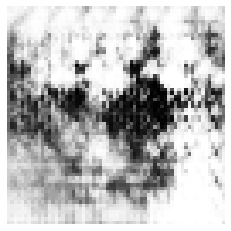

Time for epoch 64 is 16.88922667503357 sec


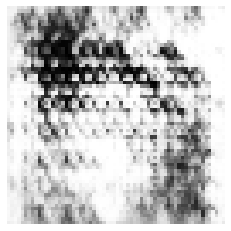

Time for epoch 65 is 22.109721660614014 sec


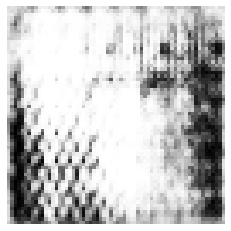

Time for epoch 66 is 16.800715923309326 sec


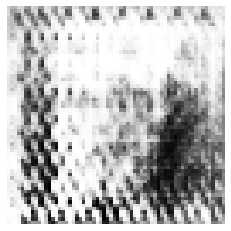

Time for epoch 67 is 16.817948579788208 sec


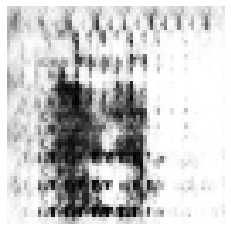

Time for epoch 68 is 16.718181848526 sec


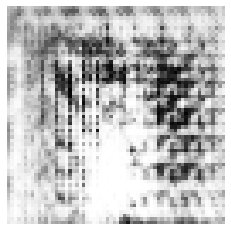

Time for epoch 69 is 16.91521668434143 sec


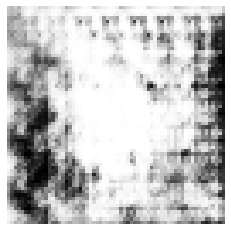

Time for epoch 70 is 17.069655418395996 sec


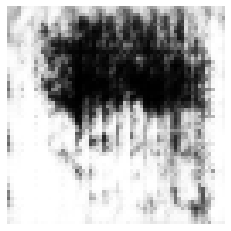

Time for epoch 71 is 16.703916311264038 sec


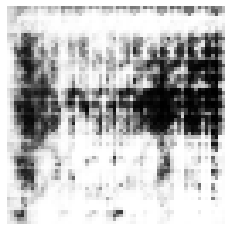

Time for epoch 72 is 17.116939783096313 sec


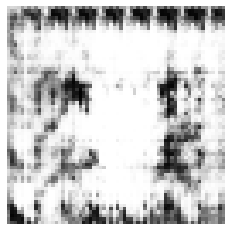

Time for epoch 73 is 16.93627953529358 sec


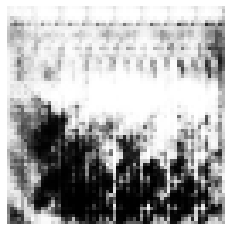

Time for epoch 74 is 16.844069480895996 sec


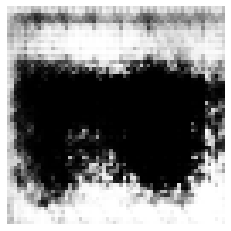

Time for epoch 75 is 16.885523080825806 sec


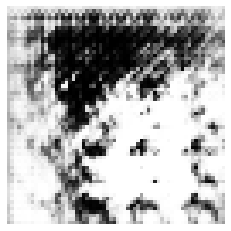

Time for epoch 76 is 17.180176258087158 sec


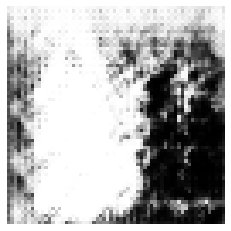

Time for epoch 77 is 16.940887928009033 sec


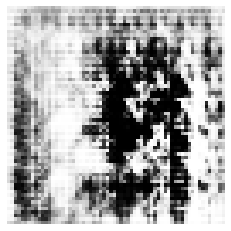

Time for epoch 78 is 16.789021730422974 sec


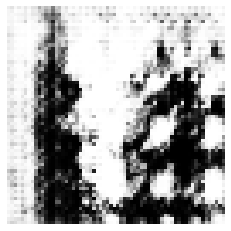

Time for epoch 79 is 16.801894426345825 sec


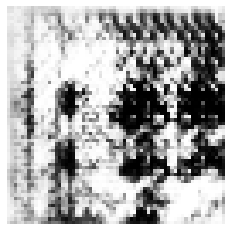

Time for epoch 80 is 16.830166578292847 sec


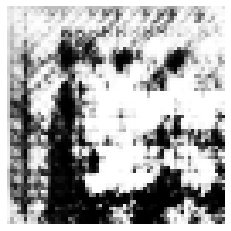

Time for epoch 81 is 16.757344961166382 sec


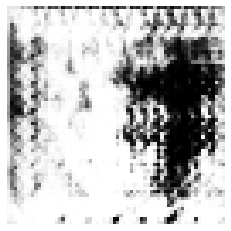

Time for epoch 82 is 16.73453140258789 sec


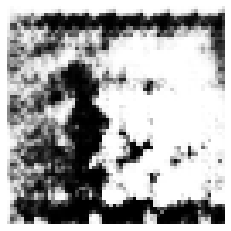

Time for epoch 83 is 16.8033607006073 sec


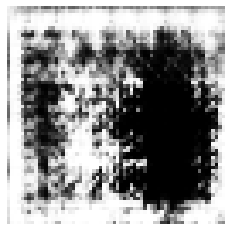

Time for epoch 84 is 17.06255578994751 sec


In [ ]:
train(train_dataset, EPOCHS)